In [1]:
import pandas as pd

In [16]:
df_Jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_Feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

## Question 1)
### Read the data for January. How many columns are there? Answer: 19



In [12]:
nb_col =  len(df_Jan.columns)
print("the number of column is : ", nb_col)
print("The different column names are: ", *df_Jan.columns, sep='\n')

the number of column is :  19
The different column names are: 
VendorID
tpep_pickup_datetime
tpep_dropoff_datetime
passenger_count
trip_distance
RatecodeID
store_and_fwd_flag
PULocationID
DOLocationID
payment_type
fare_amount
extra
mta_tax
tip_amount
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
airport_fee


## Q2. Computing duration

### Now let's compute the duration variable. It should contain the duration of a ride in minutes.

### What's the standard deviation of the trips duration in January? Answer: 42.59 minutes

In [31]:
# In order to know the duration of the trip we substract the dropoff time to the pickup time 
df_Jan["duration"] = df_Jan["tpep_dropoff_datetime"] - df_Jan["tpep_pickup_datetime"]
df_Jan['duration'] = df_Jan['duration'].apply(lambda time: time.total_seconds()/60)
std_jan = round(df_Jan["duration"].std(), 2)
mean_jan = round(df_Jan["duration"].mean(), 2)

In [33]:
print("The standard deviation of the trips duration in January is: ", std_jan, " minutes")
print("The mean of the trips duration in January is: ", mean_jan, " minutes")

The standard deviation of the trips duration in January is:  42.59  minutes
The mean of the trips duration in January is:  15.67  minutes


## Q3. Dropping outliers

### Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive). What fraction of the records left after you dropped the outliers? Answer 98%



In [38]:
import datetime
df_Jan_filtered = df_Jan[(df_Jan["duration"] <= 60.) & (df_Jan["duration"] >= 1.)]
ratio = round(100* (len(df_Jan_filtered)/len(df_Jan)), 2)
print("There are ", ratio, "% of data remaining after dropping the outliers")

There are  98.12 % of data remaining after dropping the outliers


In [40]:
import numpy as np
# Alternatively we can use IQR (Inter Quartile Range) to set the upper and lower bound.
Q1 = np.percentile(df_Jan["duration"], 25, method='midpoint')
Q3 = np.percentile(df_Jan["duration"], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR
print("the upper bout is: ", upper)
print("the lower bound is: ", lower)


the upper bout is:  35.075
the lower bound is:  -9.658333333333331


In [ ]:
# We obtain a negative lower bound which is non realistic because our studied data is a duration. 
# The utilisation of the IQR is better to use when the data distribution is "more" Gaussian in our
# case the standard deviation is so high compare to the mean that  the computation of the lower bound 
# gives a negative result ( plus the distribution is asymmetric). 

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)? (3009173, 515)

In [41]:
df_Jan_filtered[["PULocationID","DOLocationID"]] = df_Jan_filtered[["PULocationID","DOLocationID"]].astype(str)

/var/folders/_9/hgg08tyn4tlfzqvx290q7zd00000gn/T/ipykernel_81843/1148397861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Jan_filtered[["PULocationID","DOLocationID"]] = df_Jan_filtered[["PULocationID","DOLocationID"]].astype(str)


In [42]:
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_Jan_filtered[["PULocationID","DOLocationID"]].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [49]:
print(f'Dict Vectorizer : {X_train.shape}')


Dict Vectorizer : (3009173, 515)


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters, where duration is the response variable
Calculate the RMSE of the model on the training data
What's the RMSE on train?

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [54]:
y = df_Jan_filtered["duration"].values
model = LinearRegression()
reg = model.fit(X_train, y)

y_pred = reg.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y, y_pred, squared=False)}')


Train RMSE: 7.649262029221019


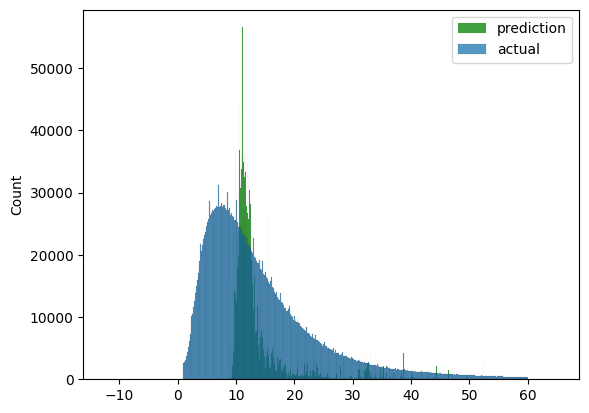

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_pred, label='prediction',color="green")
sns.histplot(y, label='actual')

plt.legend()


In [57]:
rest = y - y_pred
type(rest)

numpy.ndarray